Certain use-cases of changepoint detection are analysis of the point when
* A server began to overload.
* A campaign began to kick-in.
* A user behaviour took a drastic change
* and many more

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
#!pip install openpyxl

In [ ]:
data = pd.read_excel(r"./COAL MINING DISASTERS UK.xlsx")

In [ ]:
data

Consider the following time series of coal mine disasters. We build a model for this and attempt to estimate the point of change.

In [ ]:
data.describe()

Hence the values are in proper range and no invalid entries exist.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import pymc3 as pm

from matplotlib import cycler
colors = cycler('color',
                ['#EE6666', '#3388BB', '#9988DD',
                 '#EECC55', '#88BB44', '#FFBBBB'])
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
       axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

plt.plot(data.Year, data.Count, "*")
plt.ylabel("Number of disasters")
plt.xlabel("Year")


So most of the disasters took place at the begining,i.e, around 1860s.

We aim to find the point in time where the safety regulations started to kick-in and the number of disaster was brought under control. 

Our main assumption here is that our data is highly influenced by the safety regulations and it's changes over time.

The occurrences of disasters are thought to follow a Poisson process with a large rate parameter in the early part and one with a smaller rate in the later years.

The probability mass function of a Poisson distribution is given as
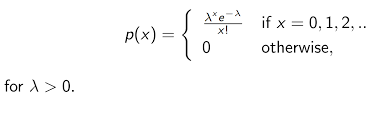


**Poisson log-likelihood** is often used to model the number of events occurring in a fixed period of time when the times at which events occurr are independent.


In [ ]:
with pm.Model() as disaster_model:  #context manager to wrap all values
    switchpoint = pm.DiscreteUniform("switchpoint", lower=data.Year.min(), upper=data.Year.max(),testval=1900)
    
    #priors for pre- and post-switch rates number of disasters
    early_rate = pm.Exponential("early_rate",1)
    late_rate = pm.Exponential("late_rate",1)
    
    #allocate appropriate Poisson rates to years before and after current
    rate = pm.math.switch(switchpoint>=data.Year,early_rate,late_rate)
    
    disasters = pm.Poisson("disasters",rate,observed=data.Count)
    
    
    

In [ ]:
with disaster_model:
    trace = pm.sample(1000)

In [ ]:
pm.traceplot(trace,combined=False, compact = False)
"""A trace plot shows the sampled values per chain and node throughout iterations. It allows us to evaluate convergence and mixing of the chains visually"""

# **Conclusion**

We observe the 5 years span which is most likely where the safety rules must have essential amendments, i.e, 1888-1893.

Reference: 
R.G. Jarrett, A note on the intervals between coal mining disasters, Biometrika, 66:191-193, 1979.